In [1]:
import pandas as pd
import os
from autoviz.AutoViz_Class import AutoViz_Class
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from fuzzywuzzy import fuzz
import matplotlib.pyplot as plt
from tqdm import tqdm
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import numpy as np

Imported AutoViz_Class version: 0.0.84. Call using:
    AV = AutoViz_Class()
    AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
Note: verbose=0 or 1 generates charts and displays them in your local Jupyter notebook.
      verbose=2 does not show plot but creates them and saves them in AutoViz_Plots directory in your local machine.


This dataset was obtained from https://www.kaggle.com/hernan4444/anime-recommendation-database-2020. Initially when using an older dataset, which contained ~30 million rows of user data, many of the recommendations were outdated and didn't provide good recommendations. I then found a newer dataset, which contained ~57 million rows, which suddenly resulted in my pandas dataframe returning memory errors when performing the pivot() operation. I had several options that I explored, but most of the operations did not fulfill the results I was looking for. 

I used pyspark to try to parallelize my operations, but because of the .agg() function and several other functions, it still took a very long time to try to unstack and pivot my table with one-hot-encoded data. 

I also tried using a chunk-based approach, by allocating the dataset into small chunks. This process was also very lengthy and resulted in memory errors, and for some reason, was getting NaN values despite having replaced those with .fillna(0). When applying the .fillna(0) operation again, it would take too long.

The last approach which is shown, was slicing the massive dataset to a manageable size, that being 1/3 of the original dataset. This means the sliced dataset may/may not represent the whole MyAnimeList community, and that the recommendations could be wrong still.

Since the data was obtained from kaggle, the data is clean and does not require scraping nor EDA. However if I was to obtain the data myself, I would have looked into if there was a python wrapper for the MAL API and construct my own dataset. Then, I would have to explore the data and see if there were "abnormal values" (e.g., having watched more episodes than those released, or those people that have abnormally high number of ratings, or people that are too old/young, etc.,), and then I would look to either impute data with the anime shows mean if given NaN, or completely remove the row of data. 

In [2]:
anime_ratings = pd.read_csv("archive/rating_2020.csv")
#anime_info = pd.read_csv("archive/anime_info_2020.csv") #contains summaries, average rating, anime_id
anime_info = pd.read_csv("archive/anime.csv") #contains summaries, average rating, anime_id

anime_user_ratings = pd.read_csv("archive/rating_complete.csv") #contains user_id, anime_id, individual ratings, 

In [37]:
anime_info

,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
anime_id,,,,,,,,,,,,,,,,,,,,,
1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...",...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48481,Daomu Biji Zhi Qinling Shen Shu,Unknown,"Adventure, Mystery, Supernatural",Unknown,盗墓笔记之秦岭神树,ONA,Unknown,"Apr 4, 2021 to ?",Unknown,Unknown,...,Unknown,Unknown,Unknown,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
48483,Mieruko-chan,Unknown,"Comedy, Horror, Supernatural",Unknown,見える子ちゃん,TV,Unknown,2021 to ?,Unknown,Kadokawa,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
48488,Higurashi no Naku Koro ni Sotsu,Unknown,"Mystery, Dementia, Horror, Psychological, Supe...",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,Unknown,"Jul, 2021 to ?",Summer 2021,Unknown,...,1.0,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown


In [31]:
plt.hist

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9
...,...,...,...
57633273,310058,502,8
57633274,310058,987,4
57633275,310058,225,8
57633276,310058,243,7


Shape of your Data Set loaded: (17562, 34)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  0
    Number of Integer-Categorical Columns =  8
    Number of String-Categorical Columns =  5
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  21
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    34 Predictors classified...
        This does not include the Target column(s)
        21 variables removed since they were ID or low-information variables
    List of variables removed: ['Score', 'Genres', 'English name', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors', 'Studios', 'Duration', 'Ranked', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6', 'Score-5', 'Score-4',

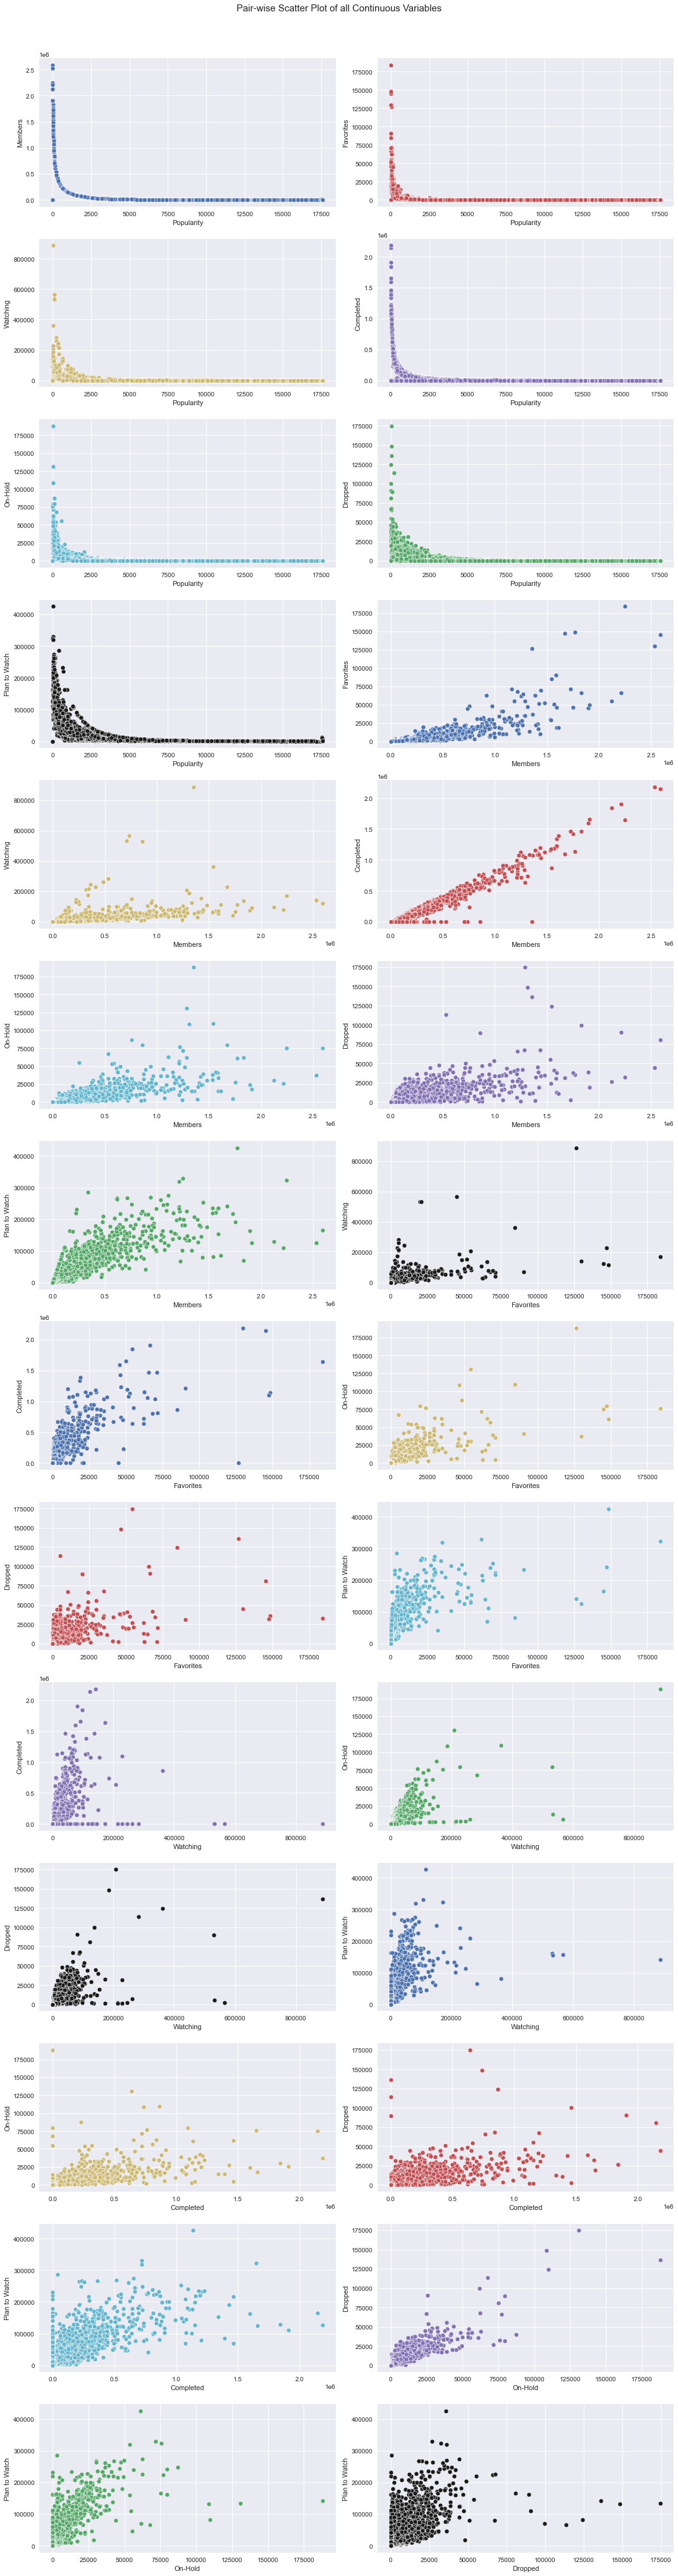

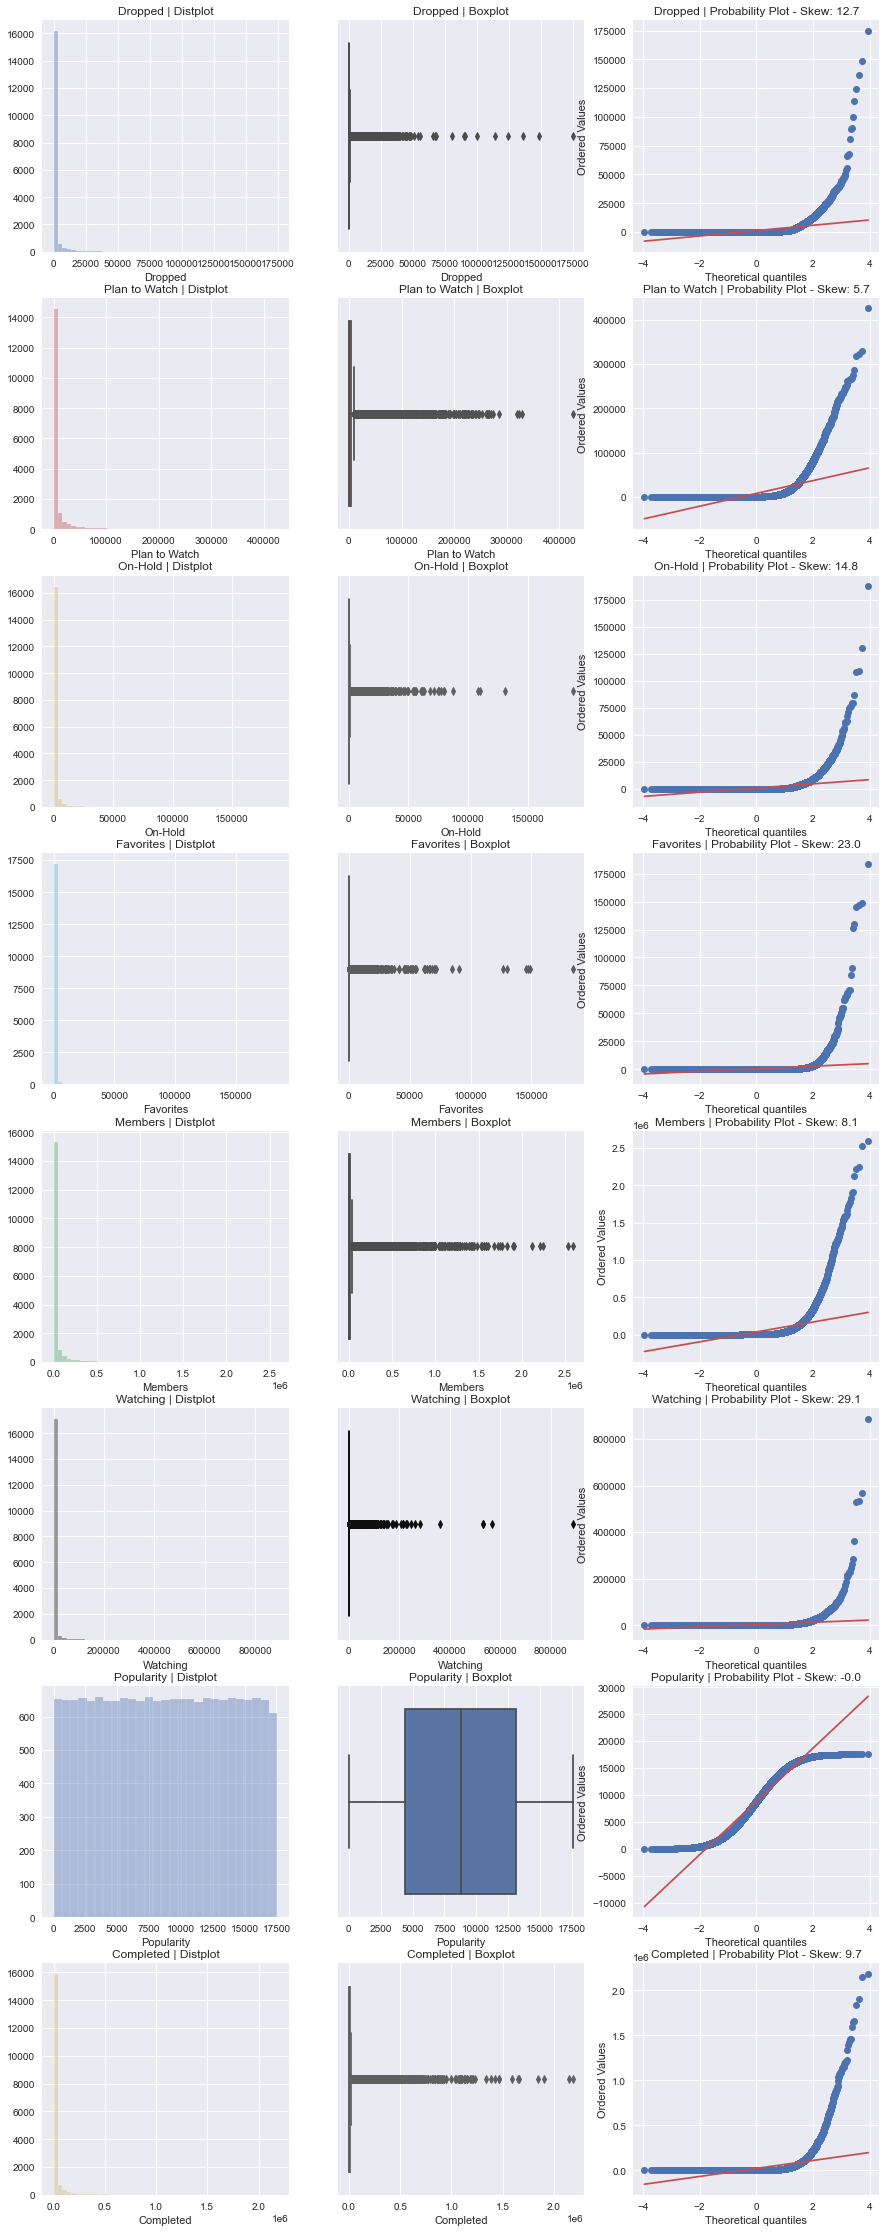

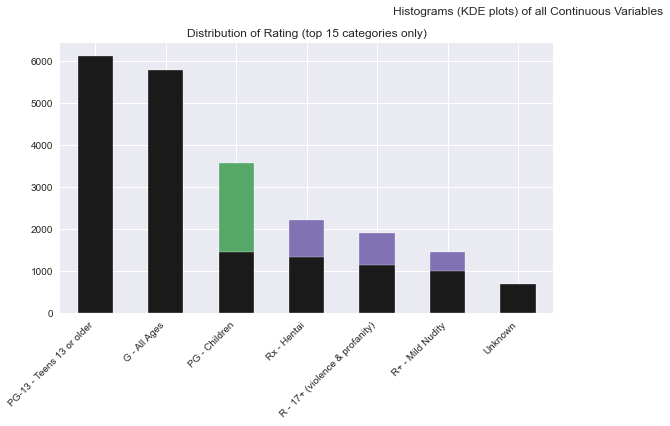

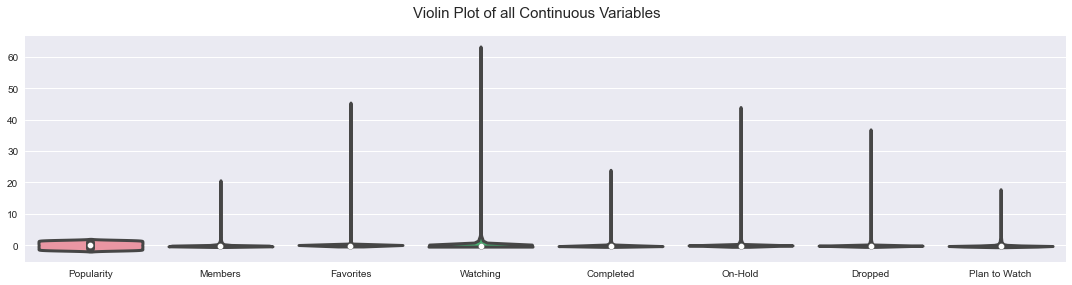

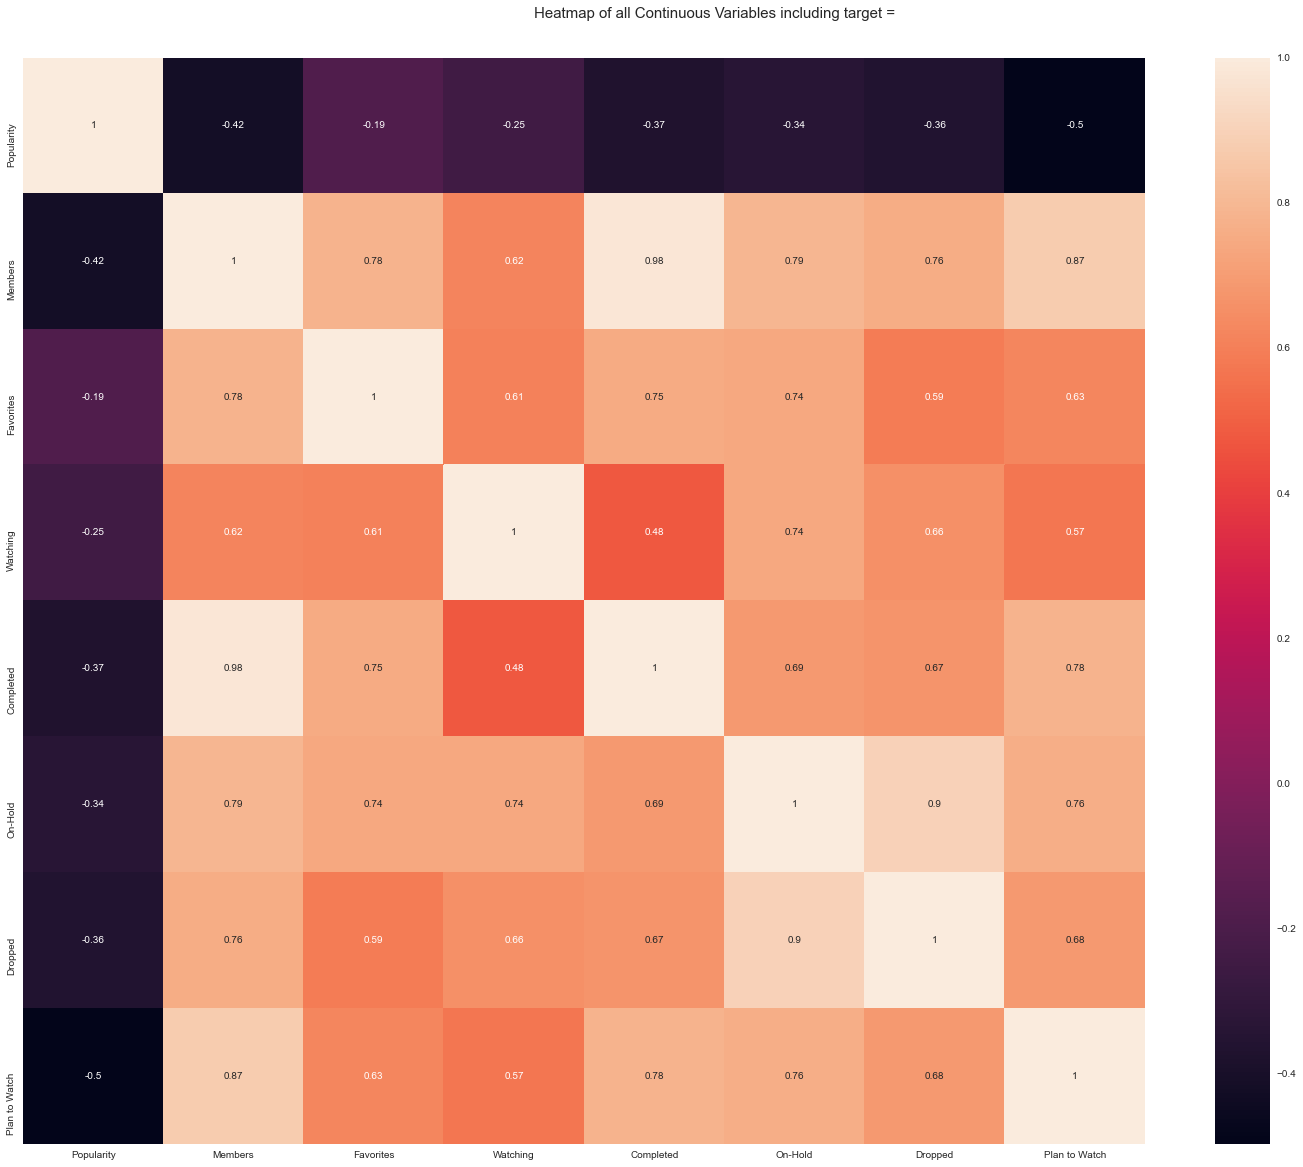

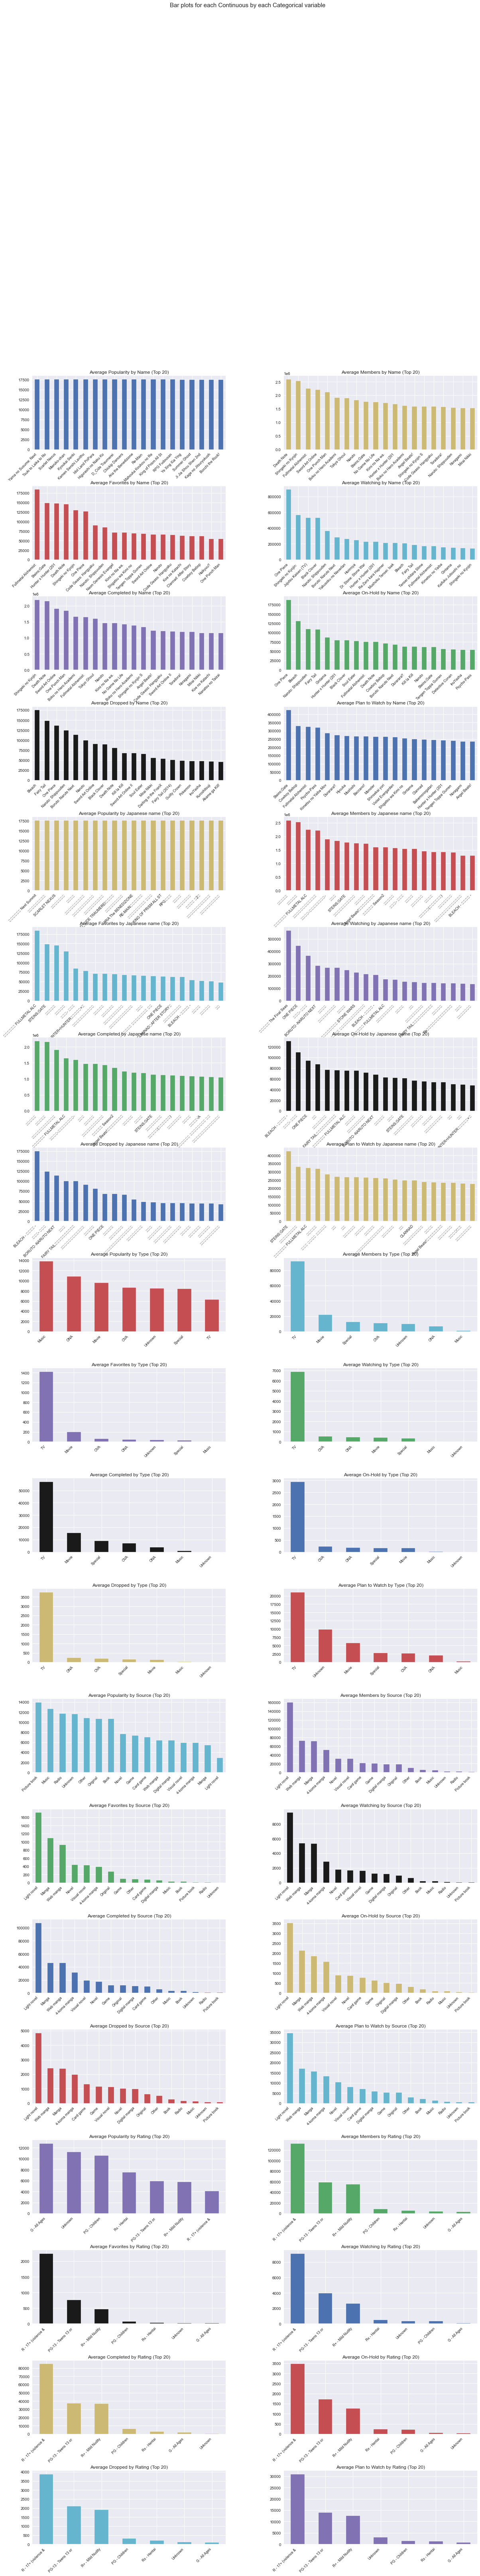

Time to run AutoViz (in seconds) = 20.934

 ###################### VISUALIZATION Completed ########################


In [27]:
AV = AutoViz_Class()
dft_users = AV.AutoViz(filename="", sep=',', depVar='', dfte=anime_info, header=0, verbose=1,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)

    Since nrows is smaller than dataset, loading random sample of 150000 rows into pandas...
Shape of your Data Set loaded: (150000, 3)
############## C L A S S I F Y I N G  V A R I A B L E S  ####################
Classifying variables in data set...
    Number of Numeric Columns =  0
    Number of Integer-Categorical Columns =  3
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  0
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  0
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    3 Predictors classified...
        This does not include the Target column(s)
        No variables removed since no ID or low-information variables found in data set
Since Number of Rows in data 150000 exceeds maximum, randomly sampling 150000 rows for EDA...
Data Set Shape: 150000 rows, 3 cols
Data 

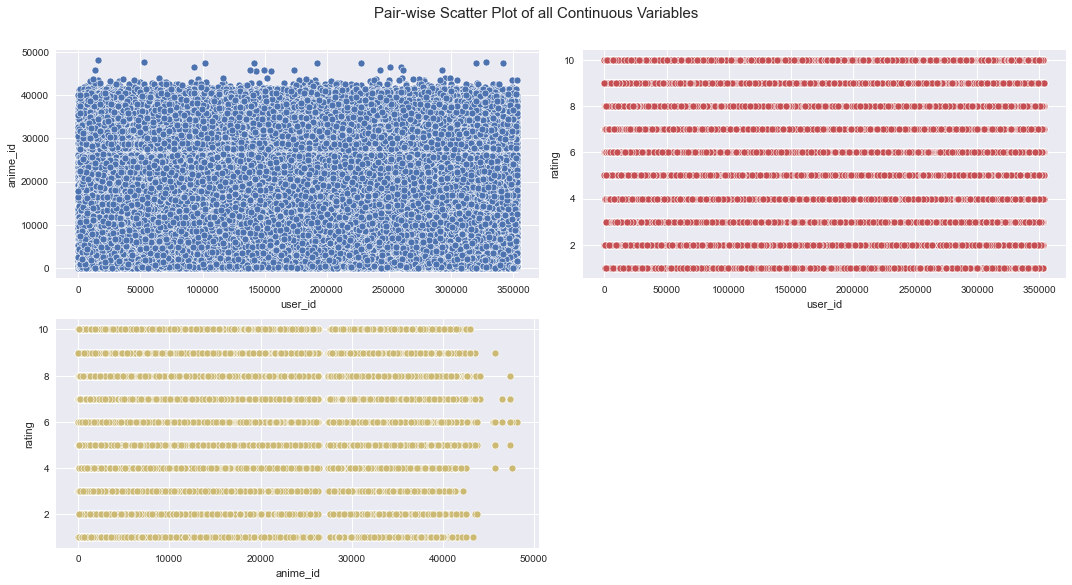

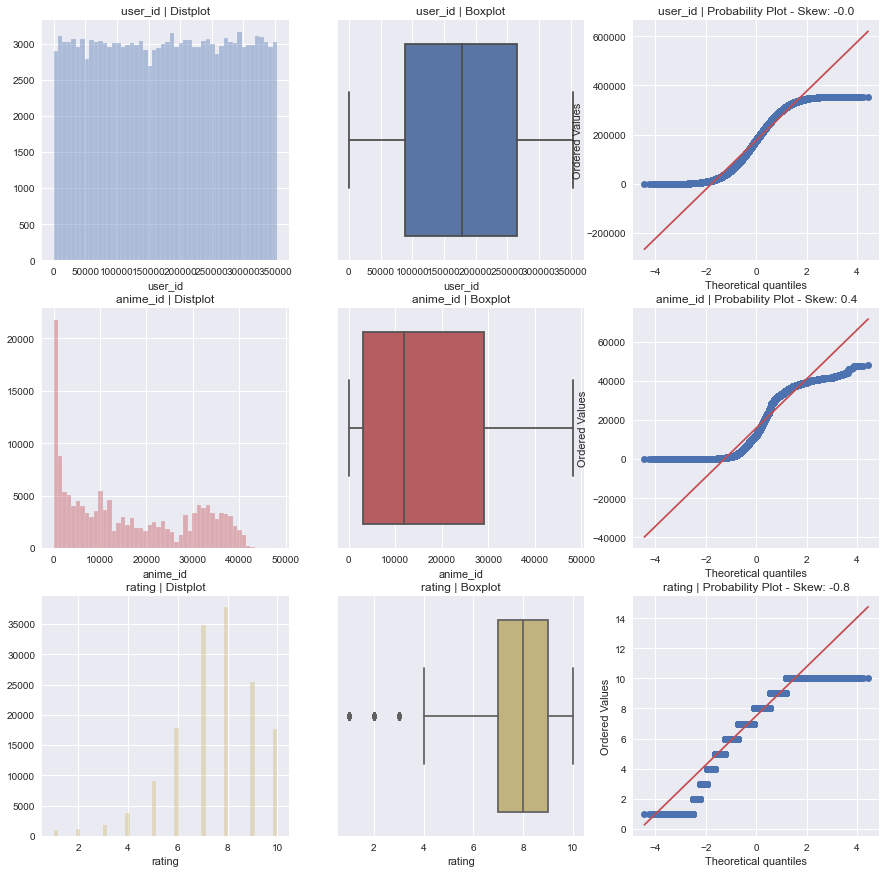

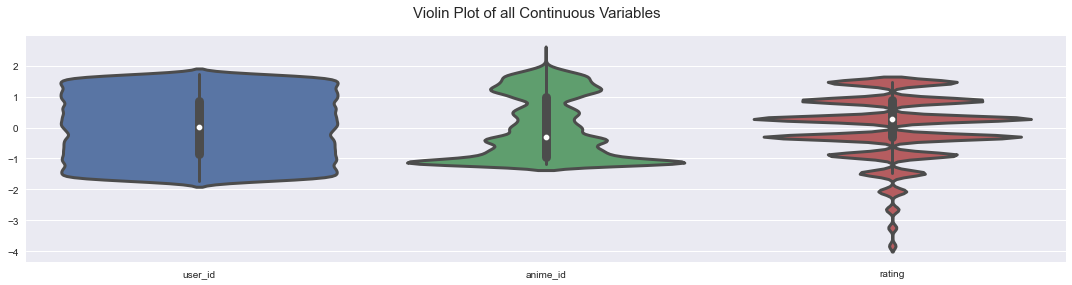

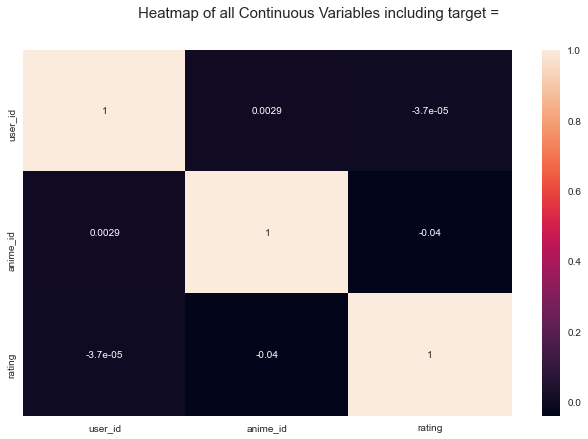

No categorical or numeric vars in data set. Hence no bar charts.
Time to run AutoViz (in seconds) = 9.131

 ###################### VISUALIZATION Completed ########################


In [28]:
AV = AutoViz_Class()
dft_users = AV.AutoViz(filename="", sep=',', depVar='', dfte=anime_user_ratings, header=0, verbose=1,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)

In [7]:
anime_info = anime_info.rename(columns={"MAL_ID": "anime_id"})

In [8]:
anime_info = anime_info.set_index("anime_id")

In [11]:
anime_map = anime_info[['Name']]
#anime_map.set_index("anime_id", drop=True, inplace=True)
anime_dict = anime_map.to_dict(orient="index")


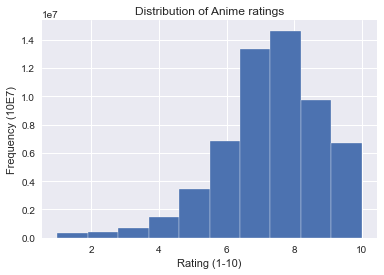

In [29]:
plt.hist(anime_ratings.rating)
plt.xlabel('Rating (1-10)')
plt.ylabel('Frequency (10E7)')
plt.title("Distribution of Anime ratings")
plt.show()

In [18]:
anime_ratings.head()

,user_id,anime_id,rating
0,0,430,9
1,0,1004,5
2,0,3010,7
3,0,570,7
4,0,2762,9


In [30]:
anime_user_ratings = anime_user_ratings[["user_id","anime_id","rating"]]
anime_user_ratings['user_id'] = anime_user_ratings.groupby(['user_id']).ngroup()

In [3]:
anime_user_ratings_split = anime_user_ratings.iloc[:20000000]

In [4]:
score_ratings = anime_user_ratings_split.pivot(index="anime_id",columns = 'user_id', values='rating').fillna(0)

In [5]:
score_ratings

user_id,0,1,2,3,4,5,6,7,8,10,...,122949,122950,122951,122952,122954,122955,122956,122957,122958,122959
anime_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,9.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47614,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
anime_map = {anime: i for i, anime in enumerate(list(anime_info.loc[score_ratings.index].Name))
            }

In [17]:
spar_mat = csr_matrix(score_ratings.values)

In [18]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [19]:
def anime_searcher(map_dict, input_anime):
    match_tuple = []
    for title, idx in map_dict.items():
        ratio = fuzz.ratio(title.lower(), input_anime.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('not found')
        return
    print('found possible matches: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

def make_recommendation(knn_model, data, map_dict, input_anime, n_recommendations):

    # fit
    knn_model.fit(data)
    # get input movie index
    print('You have input movie:', input_anime)
    idx = anime_searcher(map_dict, input_anime)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = knn_model.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in map_dict.items()}
    # print recommendations
    print('Recommendations for {}:'.format(input_anime))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [26]:
my_favorite = 'One piece'

make_recommendation(
    knn_model=knn_model,
    data=spar_mat,
    input_anime=my_favorite,
    map_dict=anime_map,
    n_recommendations=10)

You have input movie: One piece
found possible matches: ['One Piece', 'One Piece Recap', 'Piece', 'One Piece Film: Z', 'One Piece Movie 1', 'Neko Pitcher', 'Love² Police', 'Pan de Peace!', 'SNS Police', 'Moon Pride', 'One Piece Film: Gold', 'One Piece: Cry Heart', 'Onegai☆Teacher', 'Monkey Peak', 'Ange Vierge']

Recommendation system start to make inference
......

Recommendations for One piece:
1: Tokyo Ghoul:re 2nd Season, with distance of 0.9901360074426557
2: Isekai Quartet 2, with distance of 0.9900406902907309
3: K-On!!: Keikaku!, with distance of 0.9899646186616234
4: Re:Zero kara Hajimeru Isekai Seikatsu - Memory Snow, with distance of 0.9870354141392192
5: Himouto! Umaru-chan R, with distance of 0.9868155254204269
6: Nichijou: Nichijou no 0-wa, with distance of 0.9855393504752464
7: Poputepipikku, with distance of 0.9851838827397574
8: Uzaki-chan wa Asobitai!, with distance of 0.9800262681580143
9: Kishibe Rohan wa Ugokanai, with distance of 0.9765322548437998
10: Onnanoko ni 

In [ ]:
'''findings:
it tends to recommend very popular shows and avoids niche shows
not very high recommendations
can only take 1 input which sucks


'''